In [2]:
import tensorflow as tf

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [60]:
import pandas as pd

<BarContainer object of 4 artists>

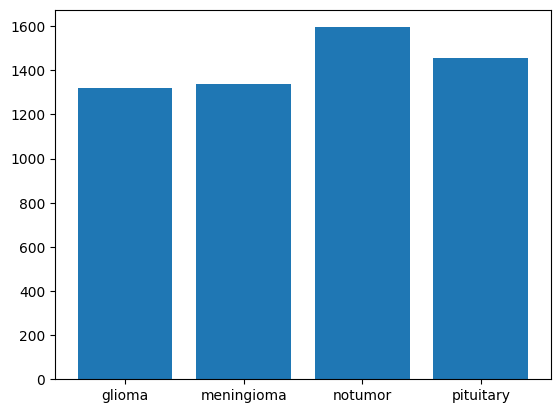

In [4]:
# visualizing images across categories/labels and their class distribution

path = 'C:/img/brain/training'
labels = os.listdir(path)

label_count = []
label_sample = []  # storing image count and sample image for visualization purpose
for label in labels:
    label_path = os.path.join(path, label)
    images = os.listdir(label_path)
    image = cv.imread(os.path.join(label_path, images[0]))
    label_count.append(len(images)), label_sample.append(image)

# class distribution
plt.bar(labels, label_count)

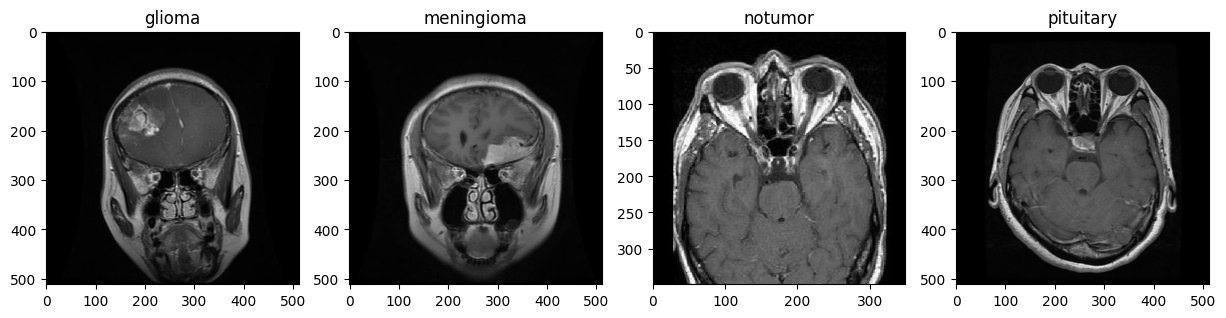

In [5]:
# sample images
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax = axes[i]
    ax.imshow(label_sample[i])
    ax.set_title(labels[i])

In [6]:
# checking distribution of image sizes

def get_image_info(folder_path, want_data=False):
    if want_data:
        image_data = {label: [] for label in labels}
    size_dict = {label: [] for label in labels}
    for label in labels:
        label_path = os.path.join(folder_path, label)
        images = os.listdir(label_path)
        for image in images:
            image_path = os.path.join(label_path, image)
            image_np = cv.imread(image_path)
            if want_data:
                image_data[label].append(image_np)
            size_dict[label].append(image_np.shape)
    if want_data:
        return size_dict, image_data
    return size_dict

training_path = "C:/img/brain/training"
testing_path = "C:/img/brain/testing"
training_sizes = get_image_info(training_path)
testing_sizes = get_image_info(testing_path)

KeyboardInterrupt: 

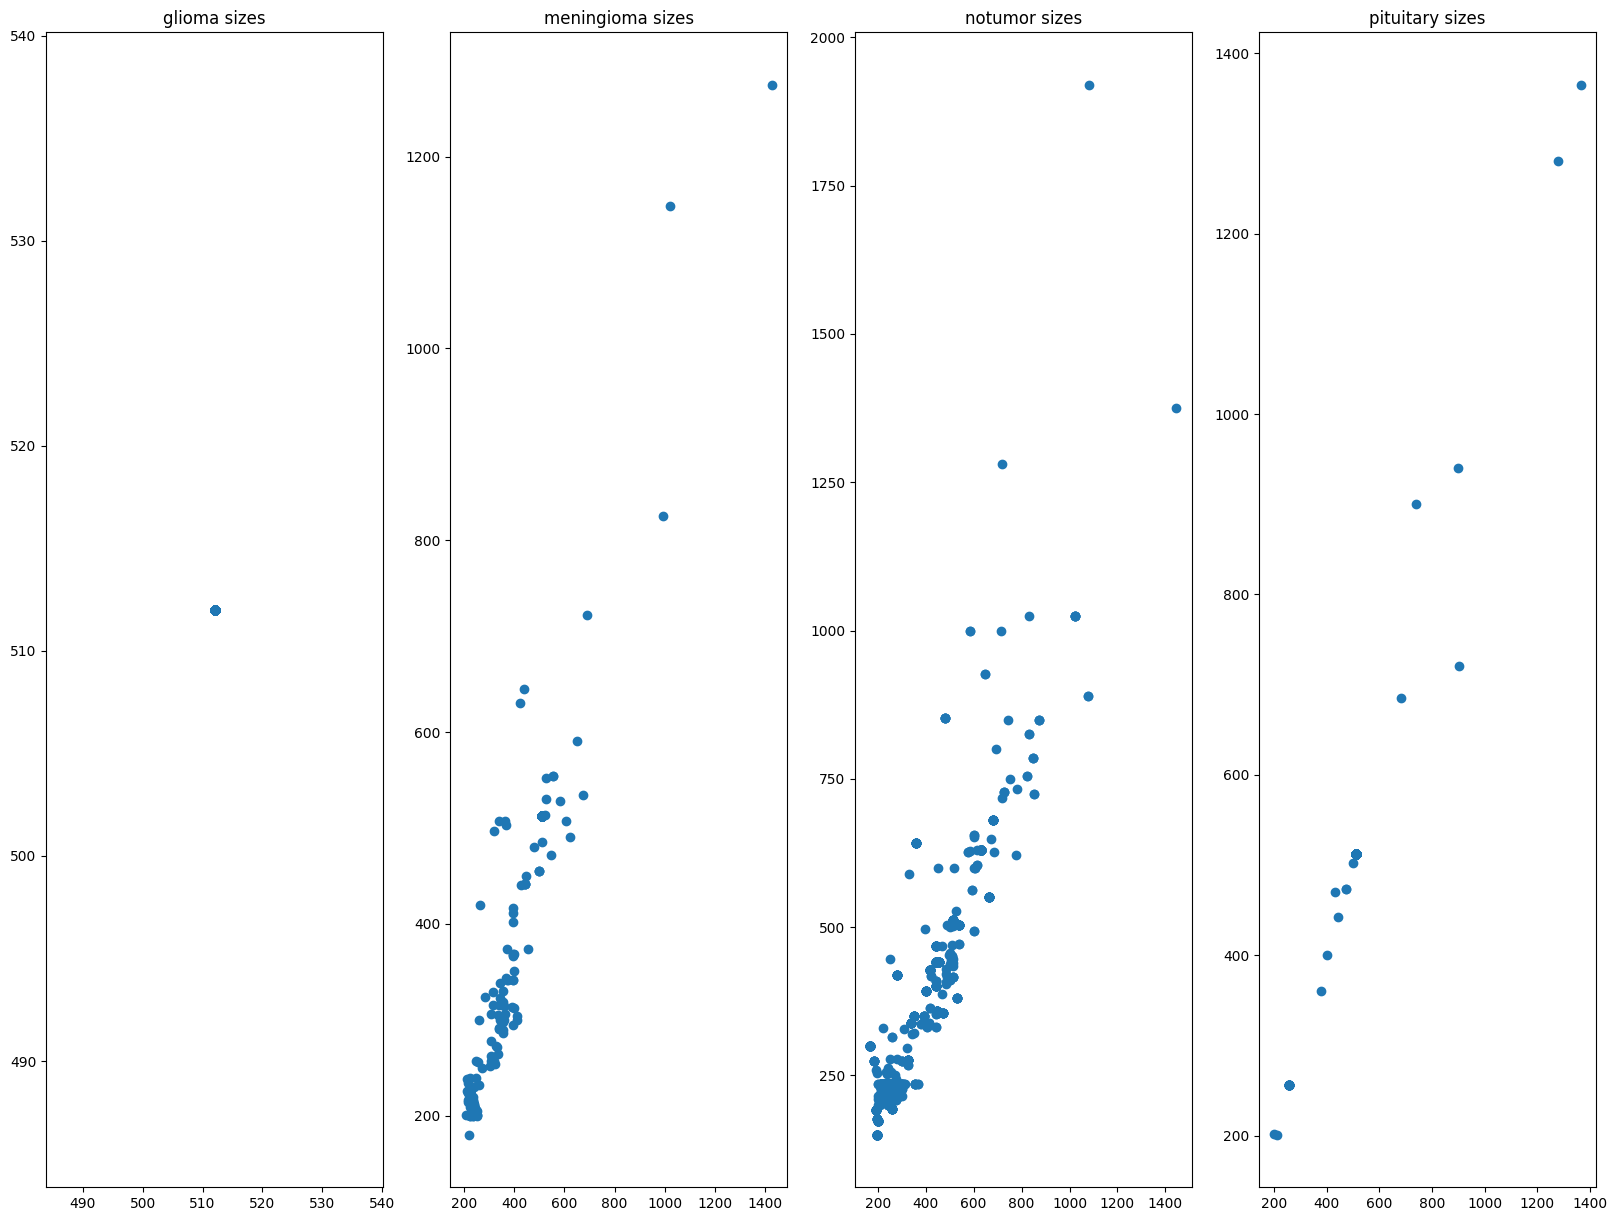

In [6]:
# visualizing sizes for training and testing sets
def plot_sizes(data):
    fig, axes = plt.subplots(1, 4, figsize=(20, 15))
    for i in range(len(labels)):
        arr = np.array(data[labels[i]])
        axes[i].scatter(arr[:, 0], arr[:, 1])
        axes[i].set_title(f"{labels[i]} sizes")

plot_sizes(training_sizes) # sizes of images accross labels

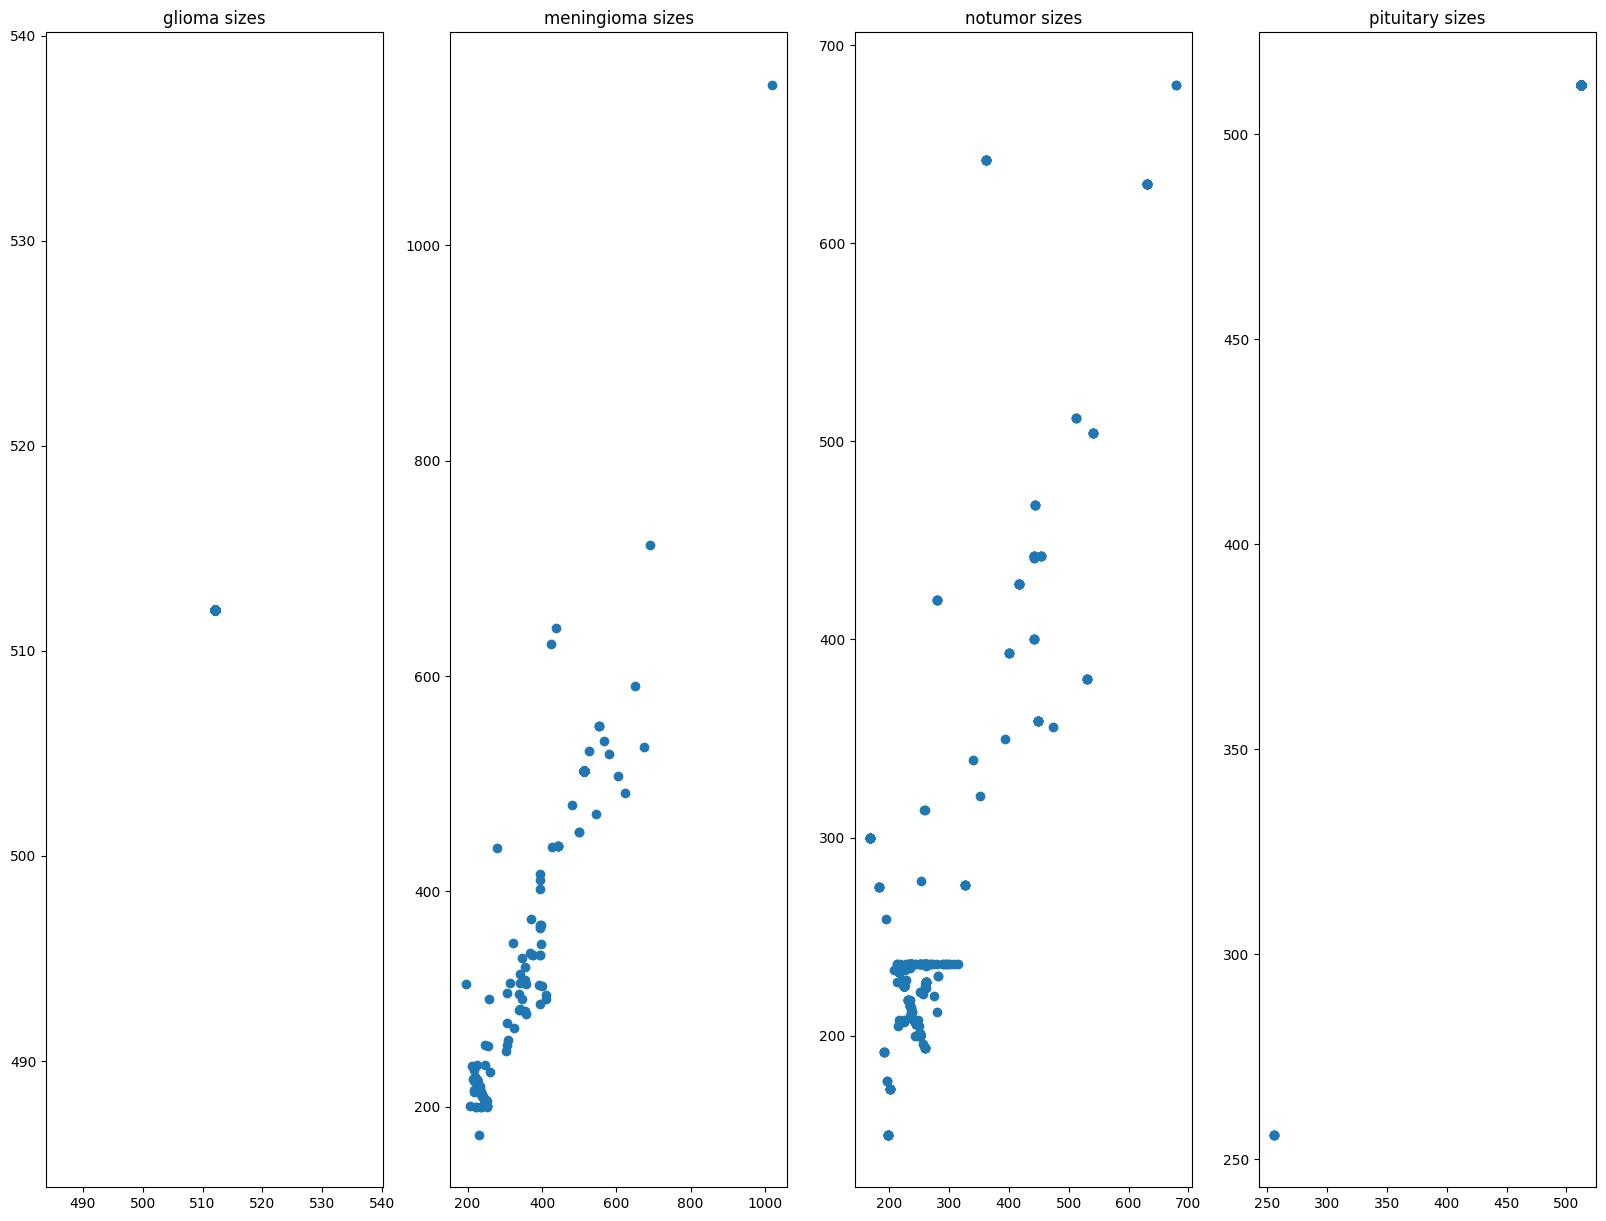

In [7]:
plot_sizes(testing_sizes)

In [8]:
# data preprocessing
# resizing images to 224*224 sizes
def resize_dataset(src_path, dest_path):
    train_test = os.listdir(src_path)
    data_path = os.path.join(dest_path, "resized_brain")
    if os.path.isdir(data_path):
        return
    os.makedirs(data_path, exist_ok=True)
    for i in train_test:
        tt_path = os.path.join(data_path, i)
        os.makedirs(tt_path, exist_ok=True)
        categories = os.listdir(os.path.join(src_path, i))
        for cat in categories:
            cat_path = os.path.join(tt_path, cat)
            os.makedirs(cat_path, exist_ok=True)
            images = os.listdir(os.path.join(src_path, i, cat))
            for img in images:
                image = cv.imread(os.path.join(src_path, i, cat, img))
                resized_image = cv.resize(image, (224, 224))
                cv.imwrite(os.path.join(cat_path, f"resized_{img}"), resized_image)

resize_dataset('C:/img/brain', 'C:/img')

In [9]:
training_path = "C:/img/resized_brain/training"
testing_path = "C:/img/resized_brain/testing"
training_sizes = get_image_info(training_path)
testing_sizes = get_image_info(testing_path)

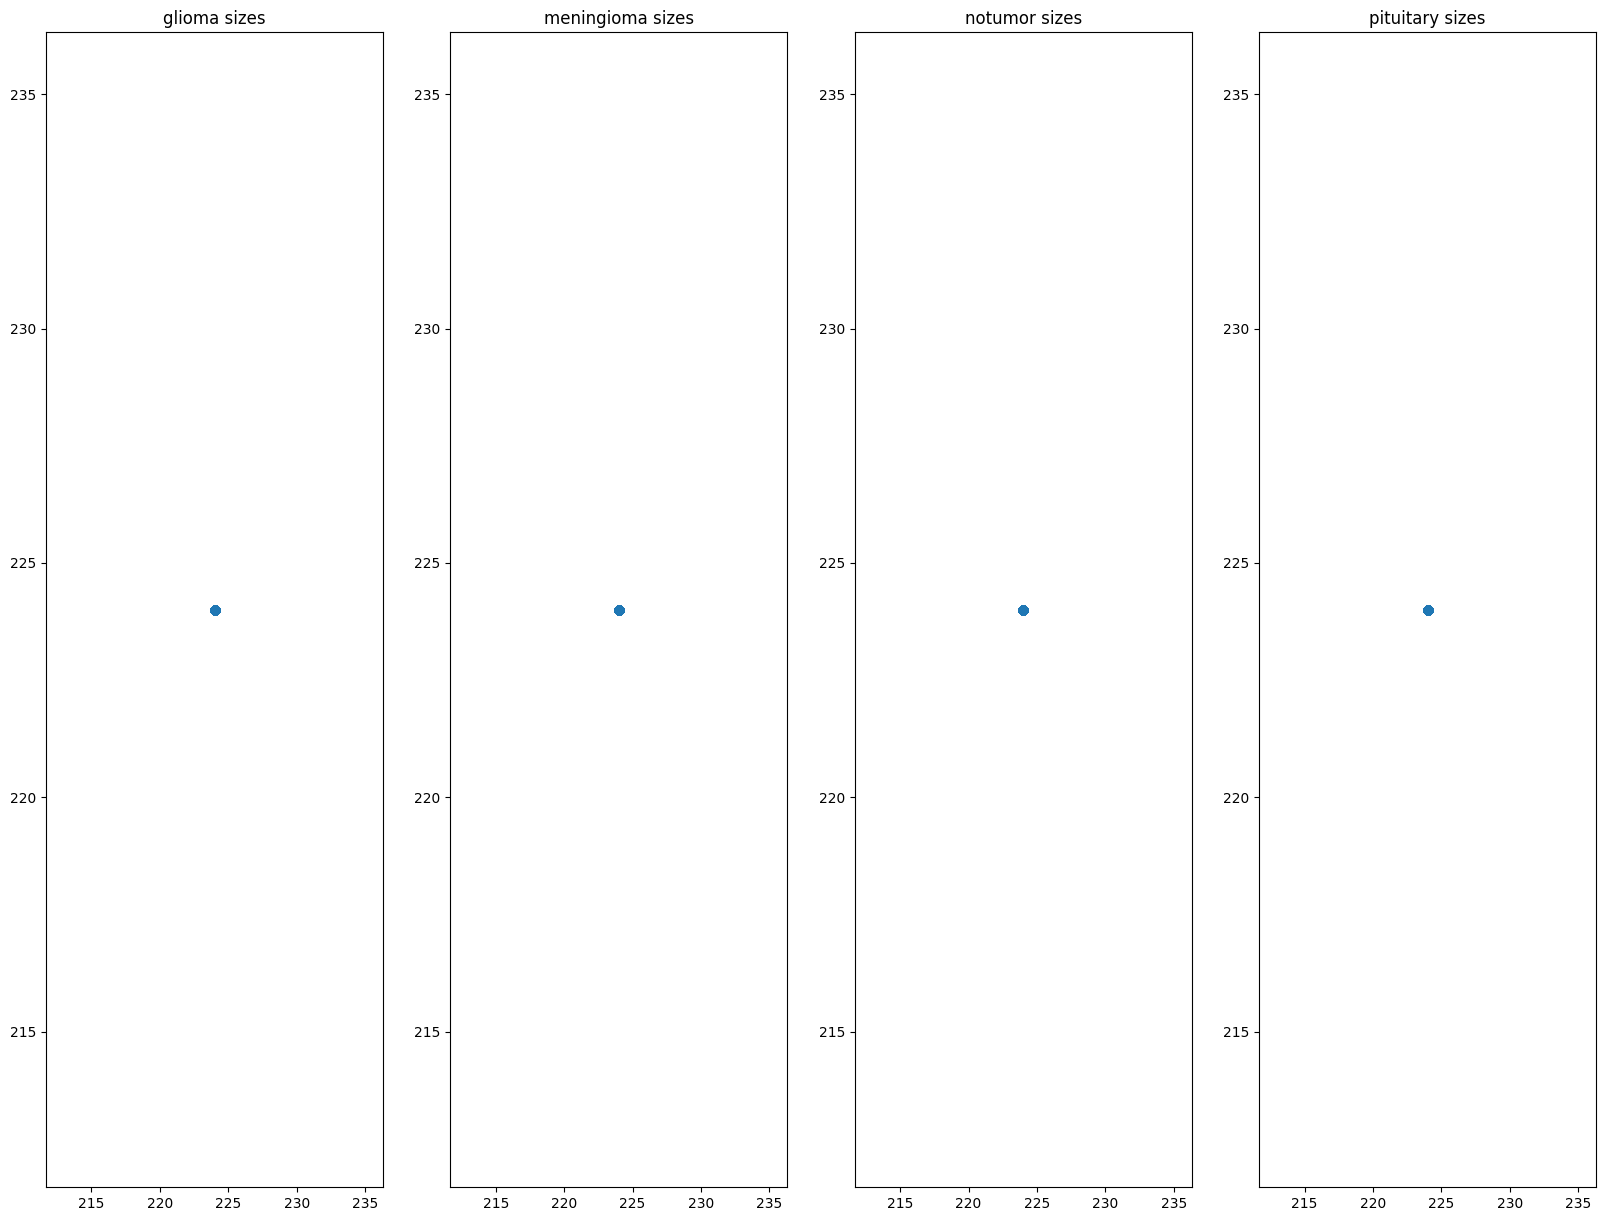

In [10]:
plot_sizes(training_sizes) 

In [78]:
# creating a tf.data.Dataset instance for training instance with pre-processing pipeline
from sklearn.model_selection import train_test_split

class MyCatEncoder(tf.keras.layers.Layer):
    def __init__(self, labels, **kwargs):
        super().__init__(**kwargs)
        self.labels = labels
        self.lookup_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(
                                            keys=labels,
                                            values=range(len(labels)),
                                            key_dtype=tf.string,
                                            value_dtype=tf.int64
        ),
                                            default_value=-1)
        self.num_labels = len(labels)
        self.encoder = tf.keras.layers.CategoryEncoding(num_tokens=self.num_labels,
                                                        output_mode="one_hot")

    def call(self, label):
        index = self.lookup_table.lookup(label)
        one_hot = self.encoder(index)
        return one_hot

def load_images_with_labels(folder_path, encoder, get_validation=False):
    label = tf.strings.split(folder_path, "/")[-1]
    image_paths = tf.io.matching_files(tf.strings.join([folder_path,"/", "*.jpg"]))
    image_paths = tf.random.shuffle(image_paths)
    one_hot_label = encoder(label)[0]

    def preprocess(p):
            image = tf.image.decode_jpeg(tf.io.read_file(p))
            return image/255, one_hot_label
        
    if get_validation:
        num_validation = int(tf.shape(image_paths)[0]/5)
        train_paths, val_paths = image_paths[:-num_validation], image_paths[-num_validation:]
        train_dataset, val_dataset = tf.data.Dataset.from_tensor_slices(train_paths), tf.data.Dataset.from_tensor_slices(val_paths)
        train_dataset, val_dataset = train_dataset.map(
            lambda x: preprocess(x),
            num_parallel_calls=tf.data.AUTOTUNE
        ), val_dataset.map(
                lambda x: preprocess(x),
                num_parallel_calls=tf.data.AUTOTUNE
        )
        return train_dataset, val_dataset
    else:
        dataset = tf.data.Dataset.from_tensor_slices(image_paths)
        dataset = dataset.map(
                lambda x: preprocess(x),
                num_parallel_calls=tf.data.AUTOTUNE
        )
        return dataset

def get_dataset(folder_path, n_readers=4, get_validation=False):
    labels = os.listdir(folder_path)
    catencoder = MyCatEncoder(labels)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels).map(lambda x: tf.strings.join([folder_path, "/", x]))
    if get_validation:
        train, val = [], []
        for label in label_dataset:
            train_ds, val_ds = load_images_with_labels(label, catencoder, get_validation=True)
            train.append(train_ds)
            val.append(val_ds)
        training_set = tf.data.Dataset.sample_from_datasets(train)
        val_set = tf.data.Dataset.sample_from_datasets(val)
        return training_set.batch(32).prefetch(1), val_set.batch(32).prefetch(1)
    else:
        dataset = label_dataset.interleave(
            lambda x: load_images_with_labels(x, catencoder, get_validation),
            cycle_length=n_readers,
            num_parallel_calls=tf.data.AUTOTUNE
        )
        return dataset.batch(32).prefetch(1)

training_dataset, validation_dataset = get_dataset("C:/img/resized_brain/training", get_validation=True)

In [79]:
testing_dataset = get_dataset("C:/img/resized_brain/testing")

In [28]:
def conv2D_block(X, f, k, s, pool, ms):
    conv_output = tf.keras.layers.Conv2D(f, k, s, activation="relu")(X)
    tf.print(conv_output.shape)
    return tf.keras.layers.MaxPool2D(pool, strides=ms)(conv_output)
def my_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    conv1 = conv2D_block(inputs, 6, 5, (1, 1), 2, 2)
    conv2 = conv2D_block(conv1, 15, 5, (1, 1), 2, 2)
    conv3 = conv2D_block(conv2, 30, 4, (1, 1), 2, 2)
    conv4 = conv2D_block(conv3, 100, 5, (1, 1), 3, 3)
    #conv4_shape = tf.keras.layers.Lambda(lambda x: tf.print("Shape before flattening:", tf.shape(x)))(conv4) # Ensure the shape is correct before Flatten layer 
    #conv4_shape_fixed = tf.keras.layers.Lambda(lambda x: x, output_shape=lambda s: s)(conv4)
    global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(conv4)
    dense1 = tf.keras.layers.Dense(50, activation="relu")(global_avg_pool)
    output = tf.keras.layers.Dense(4, activation="softmax")(dense1)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [29]:
my_model = my_model()

(None, 220, 220, 6)
(None, 106, 106, 15)
(None, 50, 50, 30)
(None, 21, 21, 100)


In [30]:
my_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 15)        │           2,265 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 30)          │           7,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 100)         │          75,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 100)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,305 (352.75 KB)

 Trainable params: 90,305 (352.75 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
my_model.compile(loss="categorical_crossentropy", 
                 optimizer="adam",
                 metrics=['accuracy'])

In [66]:
history = my_model.fit(training_dataset, epochs=1, validation_data=validation_dataset)

    143/Unknown 239s 2s/step - accuracy: 0.9306 - loss: 0.1954

C:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


143/143 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9306 - loss: 0.1952 - val_accuracy: 0.8940 - val_loss: 0.4318


In [72]:
from sklearn.metrics import accuracy_score


def get_test_accuracy(my_model):
    y_pred_ext = my_model.predict(testing_dataset)
    y_pred = tf.argmax(y_pred_ext, axis=1)
    y_pred = y_pred.numpy()
    y_true = []
    for batch, label in testing_dataset:
        y_true.extend(label.numpy())
    y_true = np.array(y_true).argmax(axis=1)
    return accuracy_score(y_true, y_pred)

In [74]:
get_test_accuracy(my_model)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step


C:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


0.8291380625476735

In [86]:
# using transfer learning
from tensorflow.keras.applications import ResNet50

def my_resnet_model():
    inputs = tf.keras.Input(shape=[224, 224, 3])
    resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)
    resnet.trainable = False
    res = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
    x1 = tf.keras.layers.Dense(250, activation="relu")(res)
    x2 = tf.keras.layers.Dense(100, activation="relu")(x1)
    x3 = tf.keras.layers.Dense(50, activation="relu")(x2)
    output = tf.keras.layers.Dense(4, activation="softmax")(x3)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [87]:
my_resnet_model = my_resnet_model()

In [88]:
my_resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,130,316 (92.05 MB)

 Trainable params: 542,604 (2.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [89]:
my_resnet_model.compile(loss="categorical_crossentropy", 
                 optimizer="adam",
                 metrics=['accuracy'])

In [90]:
history = my_resnet_model.fit(training_dataset, epochs=10, validation_data=validation_dataset)

Epoch 1/10
    143/Unknown 752s 5s/step - accuracy: 0.3607 - loss: 1.2837

C:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


143/143 ━━━━━━━━━━━━━━━━━━━━ 940s 7s/step - accuracy: 0.3613 - loss: 1.2828 - val_accuracy: 0.4601 - val_loss: 2.1185
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 847s 6s/step - accuracy: 0.4723 - loss: 1.2704 - val_accuracy: 0.4119 - val_loss: 1.8988
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 892s 6s/step - accuracy: 0.5040 - loss: 1.1461 - val_accuracy: 0.4514 - val_loss: 1.5857
Epoch 4/10
 50/143 ━━━━━━━━━━━━━━━━━━━━ 7:37 5s/step - accuracy: 0.4653 - loss: 1.3127

KeyboardInterrupt: 